In [116]:
import os
import email
from collections import Counter
import numpy as np

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

from bs4 import BeautifulSoup

from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

In [75]:
types = Counter()
msgs = []
trigger = True
for root,dirs,files in os.walk('/Users/austi/Downloads/SpamAssassinMessages/'):
    for f in files:
        with open(os.path.join(root,f),'r',encoding='latin-1') as file_handle:
            msg = email.message_from_file(file_handle,)
            type_ = msg.get_content_type()
            types[type_]+=1
            if type_ == 'multipart/mixed' and trigger:
                print(root,f)
                print('______________')
                trigger = False
                SAMPLE = msg.get_payload()
print(types)


/Users/austi/Downloads/SpamAssassinMessages/easy_ham 00067.23813c5ac6ce66fd892ee5501fd5dbd2
______________
Counter({'text/plain': 7413, 'text/html': 1193, 'multipart/alternative': 326, 'multipart/signed': 180, 'multipart/mixed': 179, 'multipart/related': 56, 'multipart/report': 5, 'text/plain charset=us-ascii': 1})


In [76]:
def return_txt(msg):
    text = '' 

    if msg.is_multipart():
        for item in msg.get_payload():
            text += return_txt(item)
    else:
        if msg.get_content_type() == 'text/plain':
            text += msg.get_payload()
        elif msg.get_content_type() == 'text/html':
            html_content = msg.get_payload(decode=True)
            soup = BeautifulSoup(html_content, 'html.parser')
            text += soup.get_text()
        else:
            text += msg.get_payload(decode=True).decode('utf-8', errors='ignore')

    return text


In [77]:
file_names = []
labels = []
messages = []
msgType = []
htmlMsgs = []
msgToFix = []

for root, dirs, files in os.walk('/Users/austi/Downloads/SpamAssassinMessages/'):
    for file in files:
        file_path = os.path.join(root, file)
        
        with open(file_path, 'r', encoding='latin-1') as file_handle:
            msg = email.message_from_file(file_handle)
            text = return_txt(msg)
                   
            messages.append(text)
            
            label = 1 if 'spam' in root else 0
            labels.append(label)
            
        file_names.append(file_path)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [78]:
for file in msgToFix:
    with open(file,'r',encoding='latin-1') as badFile:
        msg = email.message_from_file(badFile)
        for m in msg:
            print(m[2])

In [89]:
print(len(messages))
print(len(labels))
print(len(htmlMsgs))

9353
9353
0


In [80]:
messagesClean = []
for i in messages:
    words = i.split()
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
    messagesClean.append(' '.join(filtered_words))


In [81]:
for i in messagesClean:
    print(i)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [90]:
vectorizer = CountVectorizer()
textVector = vectorizer.fit_transform(messagesClean)

In [91]:
kMeans = KMeans(random_state=42)
kMeans.fit(textVector)

KMeans(random_state=42)

In [93]:
# textData = textVector.toarray()
# textData.shape


textData = textVector.tocsr()
textData.shape

(9353, 105638)

In [98]:
# cluster_column = np.array(kMeans.labels_).reshape(-1, 1)
# textClusters = np.hstack((textData,cluster_column))
# textClusters.shape



cluster_column = np.array(kMeans.labels_).reshape(-1, 1)
textClusters = hstack((textData, cluster_column))
textClusters_shape = textClusters.shape

textClusters_shape


(9353, 105639)

In [99]:
X_train, x_test, y_train, y_test = train_test_split(textClusters,labels,test_size=0.2,random_state=42)

In [100]:
nb = MultinomialNB()

In [101]:
nb.fit(textClusters,labels)

MultinomialNB()

In [103]:
# cross_val_score(nb,textClusters,labels,cv=5,n_jobs=-1,scoring='accuracy')
cross_val_score(nb,X_train, y_train,cv=5,scoring='accuracy')
    

array([0.9759519 , 0.98062792, 0.97794118, 0.98128342, 0.98663102])

In [107]:
alpha_values = [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]

accuracies = []
classification_reports = []

for alpha in alpha_values:
    nb_classifier = MultinomialNB(alpha=alpha)
    
    cv_scores = cross_val_score(nb_classifier, X_train, y_train, cv=5)
    
    nb_classifier.fit(X_train, y_train)
    
    y_pred = nb_classifier.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    
    accuracies.append(accuracy)
    classification_reports.append(classification_rep)
    
    print(f'Alpha = {alpha}:')
    print('Cross-Validation Scores:', cv_scores)
    print('Mean Cross-Validation Accuracy:', cv_scores.mean())
    print('--------------------------------------------------------\n')

Alpha = 0.001:
Cross-Validation Scores: [0.97929192 0.98196393 0.97860963 0.98596257 0.98863636]
Mean Cross-Validation Accuracy: 0.9828928802346224
--------------------------------------------------------

Alpha = 0.01:
Cross-Validation Scores: [0.98129593 0.98530394 0.97927807 0.98729947 0.98863636]
Mean Cross-Validation Accuracy: 0.9843627540285562
--------------------------------------------------------

Alpha = 0.1:
Cross-Validation Scores: [0.98129593 0.98396794 0.98262032 0.98663102 0.98930481]
Mean Cross-Validation Accuracy: 0.984764002157613
--------------------------------------------------------

Alpha = 0.5:
Cross-Validation Scores: [0.98062792 0.98263193 0.98328877 0.98462567 0.98863636]
Mean Cross-Validation Accuracy: 0.9839621310356899
--------------------------------------------------------

Alpha = 1.0:
Cross-Validation Scores: [0.9759519  0.98062792 0.97794118 0.98128342 0.98663102]
Mean Cross-Validation Accuracy: 0.9804870882585135
------------------------------------

In [108]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

In [109]:
yScore = nb.predict_proba(x_test)[:,1]
yClass = nb.predict(x_test)

In [110]:
print(len(y_test))
print(len(yScore))

1871
1871


In [111]:
fpr, tpr, threshold = roc_curve(y_test,yScore)
roc_auc = auc(fpr,tpr)

In [112]:
for i,j,k in zip(fpr,tpr,threshold):
    print(i,j,k)

0.0 0.0 inf
0.0050323508267433505 0.74375 1.0
0.0050323508267433505 0.7458333333333333 0.9999999999999716
0.0050323508267433505 0.7541666666666667 0.9999999999998863
0.0050323508267433505 0.76875 0.9999999999933209
0.0050323508267433505 0.7729166666666667 0.999999999990905
0.0050323508267433505 0.7979166666666667 0.9999999998133262
0.0050323508267433505 0.8020833333333334 0.9999999997817781
0.0050323508267433505 0.80625 0.9999999975066203
0.0050323508267433505 0.8104166666666667 0.9999999972187652
0.0050323508267433505 0.84375 0.9999976510721655
0.0050323508267433505 0.8479166666666667 0.9999975728230663
0.0050323508267433505 0.85625 0.9999936961699827
0.0050323508267433505 0.8604166666666667 0.9999924628719267
0.0050323508267433505 0.8625 0.9999912356579821
0.0050323508267433505 0.8666666666666667 0.9999797640134606
0.0050323508267433505 0.9104166666666667 0.9947764232475598
0.0050323508267433505 0.9145833333333333 0.9913193714173847
0.0050323508267433505 0.9166666666666666 0.98835888

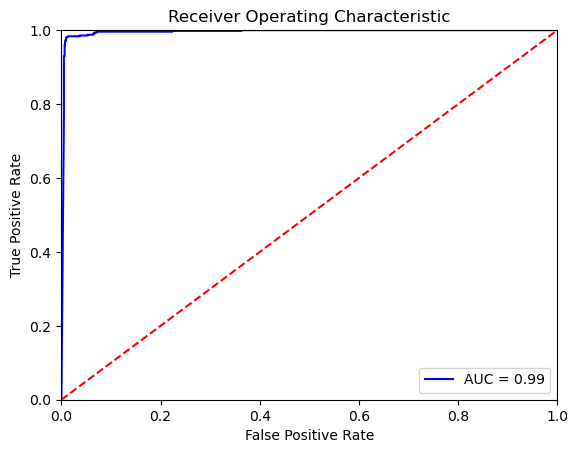

In [113]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

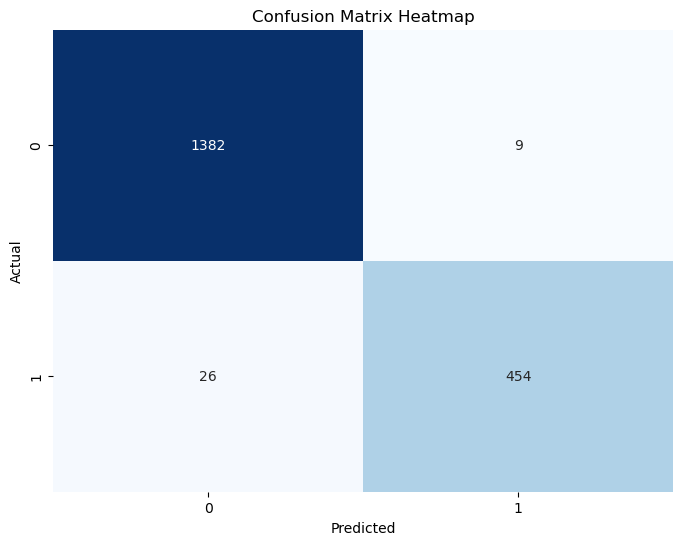

In [122]:
confusion = confusion_matrix(y_test,yClass)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()